In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
final_df = pd.read_csv("../create_datasets/final_final_possesion_df.csv")
team_ids = final_df['uniqueTeamId']

In [3]:
final_df.columns

Index(['uniqueTeamId', 'ABAB', 'ABCA', 'ABCB', 'ABCD', 'Total_Passes',
       'High_pass_Ratio_Total', 'Low_pass_Ratio_Total',
       'High_pass_Ratio_Zone2', 'Low_pass_Ratio_Zone2',
       'High_pass_Ratio_Zone1', 'Low_pass_Ratio_Zone1',
       'High_pass_Ratio_Zone3', 'Low_pass_Ratio_Zone3',
       'Backward Pass_Zone_1 Ratio', 'Backward Pass_Zone_2 Ratio',
       'Backward Pass_Zone_3 Ratio', 'Forward Pass_Zone_1 Ratio',
       'Forward Pass_Zone_2 Ratio', 'Forward Pass_Zone_3 Ratio',
       'Side Pass_Zone_1 Ratio', 'Side Pass_Zone_2 Ratio',
       'Side Pass_Zone_3 Ratio', 'Backward Pass Ratio', 'Forward Pass Ratio',
       'Side Pass Ratio', 'Total Shots', 'Far Shots Ratio',
       'Middle Distance Shots Ratio', 'Near Shots Ratio', 'Connectivity'],
      dtype='object')

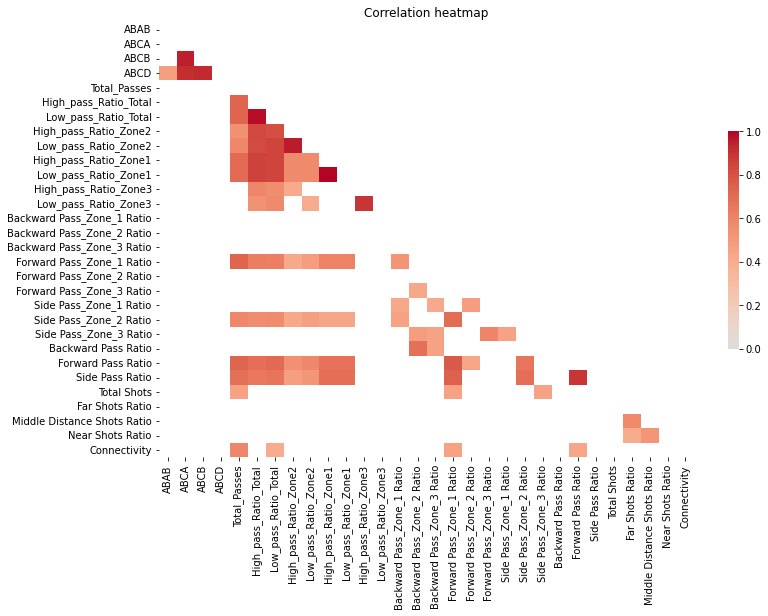

In [4]:
corr = final_df.drop(["uniqueTeamId"], axis = 1).corr().abs()
corr[corr.abs() < 0.4] = np.nan

plt.figure(figsize=(12, 8))
sns.heatmap(corr.abs(), cmap="coolwarm", 
            mask=np.triu(np.ones_like(corr.abs(), dtype=bool)),
            cbar_kws={"shrink": .5}, vmin=0, vmax=1, center= 0)
plt.title('Correlation heatmap')
plt.show()

In [5]:
final_df.set_index("uniqueTeamId", inplace = True)

In [6]:
#there are only 12 nan values.
final_df.isna().sum()

ABAB                           0
ABCA                           0
ABCB                           0
ABCD                           0
Total_Passes                   0
High_pass_Ratio_Total          0
Low_pass_Ratio_Total           0
High_pass_Ratio_Zone2          0
Low_pass_Ratio_Zone2           0
High_pass_Ratio_Zone1          0
Low_pass_Ratio_Zone1           0
High_pass_Ratio_Zone3          0
Low_pass_Ratio_Zone3           0
Backward Pass_Zone_1 Ratio     0
Backward Pass_Zone_2 Ratio     0
Backward Pass_Zone_3 Ratio     0
Forward Pass_Zone_1 Ratio      0
Forward Pass_Zone_2 Ratio      0
Forward Pass_Zone_3 Ratio      0
Side Pass_Zone_1 Ratio         0
Side Pass_Zone_2 Ratio         0
Side Pass_Zone_3 Ratio         0
Backward Pass Ratio            0
Forward Pass Ratio             0
Side Pass Ratio                0
Total Shots                    3
Far Shots Ratio                3
Middle Distance Shots Ratio    3
Near Shots Ratio               3
Connectivity                   0
dtype: int

In [7]:
final_df.fillna(0, inplace=True)

In [15]:
final_df.columns

Index(['ABAB', 'ABCA', 'ABCB', 'ABCD', 'Total_Passes', 'High_pass_Ratio_Total',
       'Low_pass_Ratio_Total', 'High_pass_Ratio_Zone2', 'Low_pass_Ratio_Zone2',
       'High_pass_Ratio_Zone1', 'Low_pass_Ratio_Zone1',
       'High_pass_Ratio_Zone3', 'Low_pass_Ratio_Zone3',
       'Backward Pass_Zone_1 Ratio', 'Backward Pass_Zone_2 Ratio',
       'Backward Pass_Zone_3 Ratio', 'Forward Pass_Zone_1 Ratio',
       'Forward Pass_Zone_2 Ratio', 'Forward Pass_Zone_3 Ratio',
       'Side Pass_Zone_1 Ratio', 'Side Pass_Zone_2 Ratio',
       'Side Pass_Zone_3 Ratio', 'Backward Pass Ratio', 'Forward Pass Ratio',
       'Side Pass Ratio', 'Total Shots', 'Far Shots Ratio',
       'Middle Distance Shots Ratio', 'Near Shots Ratio', 'Connectivity'],
      dtype='object')

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

    # Autoencoder for DEC
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


    # DEC model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super().__init__()
        self.encoder = encoder
        self.clusters = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters)**2, dim=2))
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

# Target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from kmedoids import KMedoids
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import calculate_distance_matrix
import pandas as pd
import numpy as np
import random

In [87]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def compute_indices(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            cluster_centers.append(np.zeros(X.shape[1]))
        else:
            cluster_centers.append(cluster_points.mean(axis=0))
    cluster_centers = np.array(cluster_centers)

    distances = pairwise_distances(X, cluster_centers)

    # Iwcss: Sum of squared distances to cluster centers
    Iwcss = sum(np.sum((X[labels == i] - cluster_centers[i]) ** 2) for i in range(n_clusters))

    # Isep: Mean distance between all cluster centers
    Isep = np.mean(cdist(cluster_centers, cluster_centers))

    # Idistcc and Idens with filtering for valid clusters
    valid_dists = []
    valid_dens = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) < 2:
            continue  # Skip small clusters to avoid NaN in mean/std
        distances_to_center = np.linalg.norm(cluster_points - cluster_centers[i], axis=1)
        valid_dists.append(np.mean(distances_to_center))
        valid_dens.append(np.std(distances_to_center))

    # Default to 0 if all clusters were invalid
    Idistcc = np.mean(valid_dists) if valid_dists else 0.0
    Idens = np.mean(valid_dens) if valid_dens else 0.0

    return Iwcss, Isep, Idistcc, Idens



def normalize(val, min_val, max_val, larger_is_better):
    range_ = max_val - min_val
    if np.isclose(range_, 0):
        return 1.0  # or 0.5, depending on how you want to treat flat metrics
    if larger_is_better:
        return np.clip((val - min_val) / (range_ + 1e-10), 0, 1)
    else:
        return np.clip(1 - (val - min_val) / (range_ + 1e-10), 0, 1)

In [102]:
# Min-max normalization function
def minmax_normalize(val, min_val, max_val, larger_is_better):
    if np.isclose(max_val - min_val, 0):
        return 1.0
    score = (val - min_val) / (max_val - min_val)
    return score if larger_is_better else 1 - score

results_normalized = []

# Compute global min and max values for each metric
index_min = {
    'Iwcss': min(row['Iwcss'] for row in results),
    'Isep': min(row['Isep'] for row in results),
    'Idistcc': min(row['Idistcc'] for row in results),
    'Idens': min(row['Idens'] for row in results),
}

index_max = {
    'Iwcss': max(row['Iwcss'] for row in results),
    'Isep': max(row['Isep'] for row in results),
    'Idistcc': max(row['Idistcc'] for row in results),
    'Idens': max(row['Idens'] for row in results),
}

for row in results:
    # Z-score normalization
    Iwcss_z = z_score(row['Iwcss'], index_means['Iwcss'], index_stds['Iwcss'])
    Isep_z = z_score(row['Isep'], index_means['Isep'], index_stds['Isep'])
    Idistcc_z = z_score(row['Idistcc'], index_means['Idistcc'], index_stds['Idistcc'])
    Idens_z = z_score(row['Idens'], index_means['Idens'], index_stds['Idens'])

    AC1_z = (Iwcss_z + Isep_z + Idistcc_z + Idens_z) / 4
    AC2_z = (1 * Iwcss_z + 0.5 * Isep_z + 1 * Idistcc_z + 0.25 * Idens_z) / 2.75

    # Min-max normalization
    Iwcss_m = minmax_normalize(row['Iwcss'], index_min['Iwcss'], index_max['Iwcss'], larger_is_better=False)
    Isep_m = minmax_normalize(row['Isep'], index_min['Isep'], index_max['Isep'], larger_is_better=True)
    Idistcc_m = minmax_normalize(row['Idistcc'], index_min['Idistcc'], index_max['Idistcc'], larger_is_better=False)
    Idens_m = minmax_normalize(row['Idens'], index_min['Idens'], index_max['Idens'], larger_is_better=False)

    AC1_m = (Iwcss_m + Isep_m + Idistcc_m + Idens_m) / 4
    AC2_m = (1 * Iwcss_m + 0.5 * Isep_m + 1 * Idistcc_m + 0.25 * Idens_m) / 2.75

    results_normalized.append({
        'k': row['k'],
        'method': row['method'],
        'silhouette_score': row['silhouette_score'],
        #'AC1_zscore': AC1_z,
        #'AC2_zscore': AC2_z,
        'AC1': AC1_m,
        'AC2': AC2_m
    })
    
results_zscore_df = pd.DataFrame(results_normalized)
results_zscore_df.sort_values(by=['AC2'], ascending = False)

,k,method,silhouette_score,AC1,AC2
20,4,dec,0.968740,0.961015,0.974979
13,3,dec,0.960173,0.888425,0.925198
6,2,dec,0.967010,0.889611,0.913954
27,5,dec,0.914988,0.853553,0.901797
48,8,dec,0.860668,0.774062,0.859406
55,9,dec,0.816731,0.748822,0.831566
34,6,dec,0.862139,0.746651,0.830413
62,10,dec,0.821146,0.743272,0.827519
41,7,dec,0.865194,0.717498,0.817869
59,10,kmeans_pca,0.332480,0.671629,0.733449


In [105]:
results_zscore_df

,k,method,silhouette_score,AC1,AC2
0,2,kmeans,0.140271,0.035985,0.036665
1,2,kmedoids,0.131965,0.028258,0.029952
2,2,ward,0.134040,0.001039,0.000457
3,2,kmeans_pca,0.333058,0.324671,0.461295
4,2,kmedoids_pca,0.333201,0.324034,0.460993
5,2,ward_pca,0.315466,0.310134,0.449874
6,2,dec,0.967010,0.889611,0.913954
7,3,kmeans,0.118089,0.115187,0.110711
8,3,kmedoids,0.102141,0.081981,0.084203
9,3,ward,0.088337,0.080002,0.071591


In [4]:
# data is taken from the df above
data = {
    'k': [2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,4,5,5,5,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,7,7,7,8,8,8,8,8,8,8,9,9,9,9,9,9,9,10,10,10,10,10,10,10],
    'method': [
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec',
        'kmeans', 'kmedoids', 'ward', 'kmeans_pca', 'kmedoids_pca', 'ward_pca', 'dec'
    ],
    'silhouette_score': [
        0.140271, 0.131965, 0.134040, 0.333058, 0.333201, 0.315466, 0.967010,
        0.118089, 0.102141, 0.088337, 0.338386, 0.338270, 0.260718, 0.960173,
        0.112083, 0.084221, 0.061425, 0.331182, 0.326349, 0.273253, 0.968740,
        0.099744, 0.090221, 0.054083, 0.325083, 0.318866, 0.284872, 0.914988,
        0.097234, 0.084441, 0.026337, 0.311402, 0.302947, 0.279224, 0.862139,
        0.097136, 0.075513, 0.030372, 0.318155, 0.294881, 0.252321, 0.865194,
        0.093422, 0.068372, 0.030830, 0.321760, 0.294581, 0.260582, 0.860668,
        0.089244, 0.067220, 0.026976, 0.326056, 0.308378, 0.251277, 0.816731,
        0.089749, 0.069004, 0.028205, 0.332480, 0.303751, 0.253857, 0.821146
    ],
    'AC1': [
        0.035985, 0.028258, 0.001039, 0.324671, 0.324034, 0.310134, 0.889611,
        0.115187, 0.081981, 0.080002, 0.449614, 0.449429, 0.401360, 0.888425,
        0.154834, 0.125156, 0.123091, 0.512845, 0.507680, 0.484911, 0.961015,
        0.190558, 0.165087, 0.133917, 0.556430, 0.553004, 0.541296, 0.853553,
        0.212503, 0.191154, 0.156903, 0.589495, 0.589278, 0.569046, 0.746651,
        0.231519, 0.203957, 0.168872, 0.615875, 0.610988, 0.595770, 0.717498,
        0.250632, 0.224177, 0.185330, 0.635867, 0.629224, 0.611296, 0.774062,
        0.264964, 0.227393, 0.199325, 0.655566, 0.644924, 0.624839, 0.748822,
        0.278434, 0.249336, 0.206836, 0.671629, 0.664640, 0.647584, 0.743272
    ],
    'AC2': [
        0.036665, 0.029952, 0.000457, 0.461295, 0.460993, 0.449874, 0.913954,
        0.110711, 0.084203, 0.071591, 0.559687, 0.559850, 0.525671, 0.925198,
        0.149586, 0.124632, 0.111487, 0.609878, 0.607512, 0.589904, 0.974979,
        0.183055, 0.163434, 0.124929, 0.644920, 0.643378, 0.632559, 0.901797,
        0.204565, 0.186630, 0.146218, 0.669192, 0.669314, 0.655691, 0.830413,
        0.224011, 0.201135, 0.161344, 0.689668, 0.686650, 0.674971, 0.817869,
        0.242970, 0.220762, 0.176822, 0.705748, 0.702110, 0.687852, 0.859406,
        0.256009, 0.227099, 0.190672, 0.721203, 0.715546, 0.698716, 0.831566,
        0.268429, 0.244894, 0.198988, 0.733449, 0.729842, 0.714665, 0.827519
    ]
}

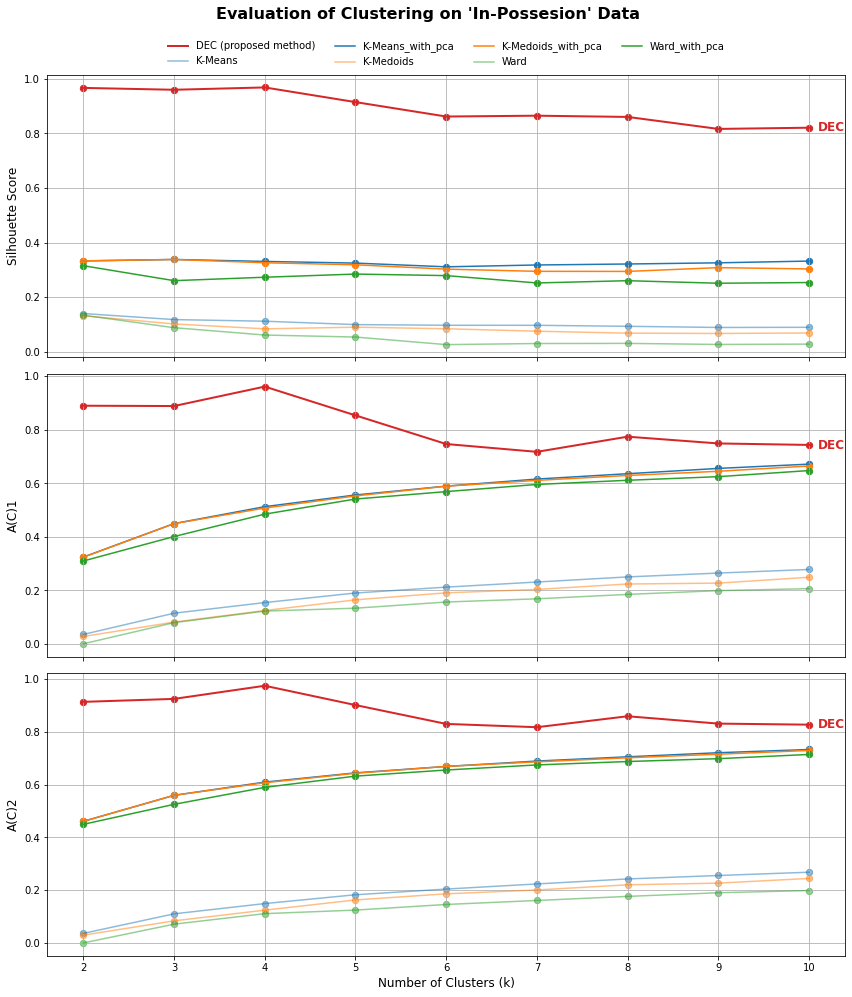

In [39]:
df = pd.DataFrame(data)

# Define mapping
old_methods = ['dec', 'kmeans', 'kmeans_pca', 'kmedoids', 'kmedoids_pca', 'ward', 'ward_pca']
new_methods = ['DEC (proposed method)', 'K-Means', 'K-Means_with_pca', 'K-Medoids', 'K-Medoids_with_pca', 'Ward', 'Ward_with_pca']
method_map = dict(zip(old_methods, new_methods))

# Apply mapping
df['method'] = df['method'].map(method_map)


# Ensure columns are correct and values are flattened
df['k'] = df['k'].astype(int)
df['silhouette_score'] = df['silhouette_score'].astype(float)
df['AC1'] = df['AC1'].astype(float)
df['AC2'] = df['AC2'].astype(float)

# Define method groups and colors
methods = ['DEC (proposed method)', 'K-Means', 'K-Means_with_pca', 'K-Medoids', 'K-Medoids_with_pca', 'Ward', 'Ward_with_pca']
base_colors = {
    'K-Means': '#1f77b4',
    'K-Medoids': '#ff7f0e',
    'Ward': '#2ca02c'
}
highlight_color = '#d62728'  # red for 'DEC (proposed method)'

# Color map with pale variants for base methods and shared colors
color_map = {
    'DEC (proposed method)': highlight_color,
    'K-Means': base_colors['K-Means'] + '80',
    'K-Means_with_pca': base_colors['K-Means'],
    'K-Medoids': base_colors['K-Medoids'] + '80',
    'K-Medoids_with_pca': base_colors['K-Medoids'],
    'Ward': base_colors['Ward'] + '80',
    'Ward_with_pca': base_colors['Ward']
}

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
metrics = ['silhouette_score', 'AC1', 'AC2']
ylabels = ['Silhouette Score', 'A(C)1', 'A(C)2']

for ax, metric, ylabel in zip(axs, metrics, ylabels):
    for method in methods:
        subset = df[df['method'] == method]
        x = subset['k'].to_numpy()
        y = subset[metric].to_numpy()
        ax.plot(x, y, label=method,
                color=color_map[method], linewidth=2 if method == 'DEC (proposed method)' else 1.5)
        ax.scatter(x, y, color=color_map[method], s=40)
        if method == 'DEC (proposed method)':
            ax.text(x[-1] + 0.1, y[-1], 'DEC', color=color_map[method],
                    fontsize=12, fontweight='bold', va='center')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)

axs[-1].set_xlabel('Number of Clusters (k)', fontsize=12)
fig.suptitle("Evaluation of Clustering on 'In-Possesion' Data", fontsize=16, fontweight='bold', y=.95)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()